<a href="https://colab.research.google.com/github/Matteo-Candi/Fine-Tuning-with-LoRA/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
%pip install datasets

In [2]:
from transformers import set_seed, BertTokenizer, TFBertModel, TFBertForSequenceClassification
from datasets import load_dataset, concatenate_datasets
import tensorflow as tf

from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

In [3]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

# Dataset

In [4]:
dataset = load_dataset("go_emotions", "simplified").shuffle(seed=17)
labels = dataset['train'].features['labels'].feature.names
dataset = dataset.remove_columns('id')

df_train = dataset['train'].to_pandas()
df_val = dataset['validation'].to_pandas()
df_test = dataset['test'].to_pandas()

model_name = "bert-base-cased"
num_labels = 28

tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
df_train

,text,labels
0,Here is their other hot wallet: the story behind,[27]
1,Look at the spine on that kid - he must get it...,"[26, 27]"
2,That can be true...,[27]
3,"Yeah, The Donald seems to spread its purging m...",[3]
4,you get an upvote for that username! I wish I ...,"[0, 20]"
...,...,...
43405,Yeah there's no reason to believe you staying ...,"[3, 10]"
43406,No lie his jumpshot is pretty If he can hit th...,[0]
43407,Redditors can really come together in a time o...,"[4, 20]"
43408,[NAME] was horribly inconsistent this year,[14]


In [6]:
def get_df_summary(df):
    label_column = df['labels'].to_list()
    flatten_col = list(itertools.chain(*label_column))
    freq_dict = dict(Counter(flatten_col))
    freq_list = list(dict(sorted(freq_dict.items())).values())
    rel_freq_list = [el / sum(freq_list) * 100 for el in freq_list]

    return rel_freq_list

In [7]:
# Get dataframes info.
train_freq = get_df_summary(df_train)
val_freq = get_df_summary(df_val)
test_freq = get_df_summary(df_test)

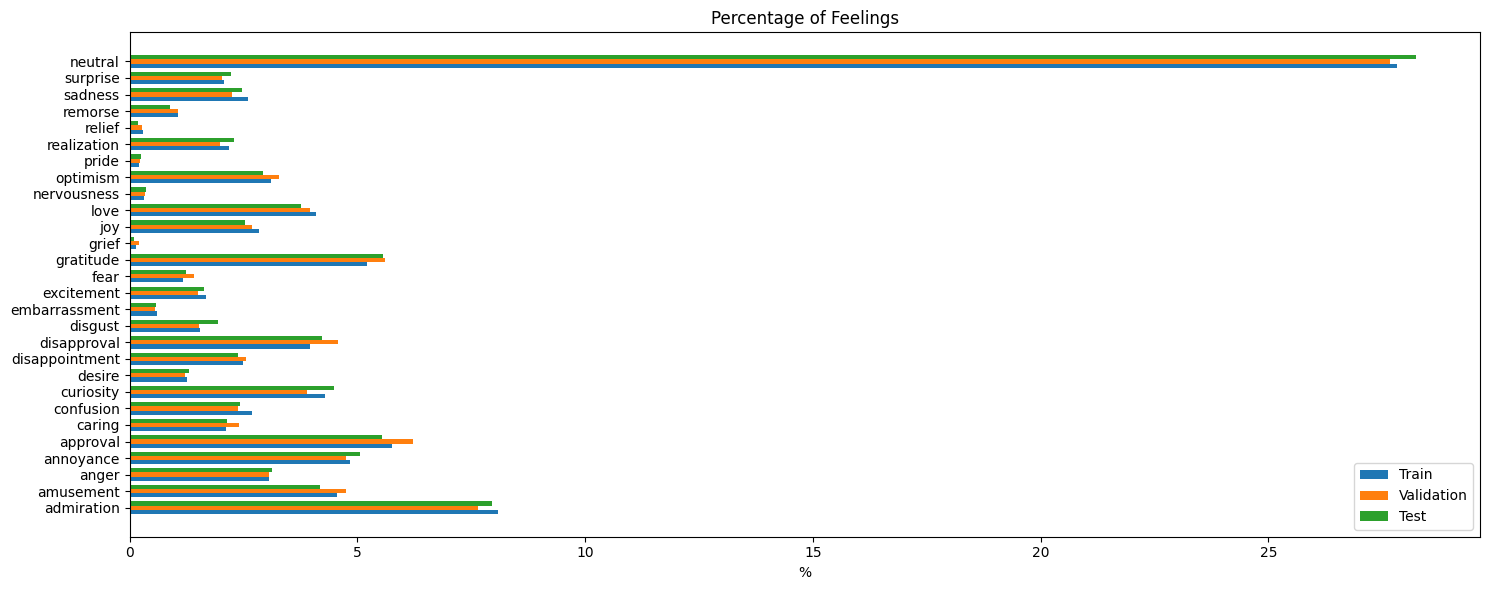

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.25
index = np.arange(len(train_freq))
bars_train = ax.barh(index, train_freq, bar_width, label='Train')
bars_val = ax.barh(index + bar_width, val_freq, bar_width, label='Validation')
bars_test = ax.barh(index + 2*bar_width, test_freq, bar_width, label='Test')
plt.xlabel('%')
plt.title('Percentage of Feelings')
plt.yticks(index + bar_width, labels)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
def tokenizer_func(text):
    '''
    Tokenizing the text using the BERT tokenizer.
    '''
    # Checking there is just one tokenization up to 316 and the second longest one is 120.
    # token_lengths = [sum(tokenized_train[i][0] != 0) for i in range(len(tokenized_train))]
    return tokenizer(text, padding = 'max_length', max_length = 120, return_tensors = "tf", truncation=True)

def one_hot_func(indices):
    '''
    Converting a value in one hot encode vector.
    '''
    one_hot_encoding = np.zeros(28, dtype=int)
    one_hot_encoding[indices] = 1
    return {'labels': one_hot_encoding}

def process_dataset_func(dataset):
    '''
    Processing the dataset to make it readable from the model.
    '''
    processed_dataset = dataset.map(lambda x: tokenizer_func(x['text']))
    processed_dataset = processed_dataset.map(lambda x: one_hot_func(x['labels']))
    processed_dataset = processed_dataset.remove_columns('text')
    return processed_dataset

In [11]:
dataset = process_dataset_func(dataset)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [12]:
batch_size = 32
tf_dataset_train = tf.data.Dataset.from_tensor_slices((dataset['train']['input_ids'], dataset['train']['labels'])).batch(batch_size)
tf_dataset_validation = tf.data.Dataset.from_tensor_slices((dataset['validation']['input_ids'], dataset['validation']['labels'])).batch(batch_size)
tf_dataset_test = tf.data.Dataset.from_tensor_slices((dataset['test']['input_ids'], dataset['test']['labels'])).batch(batch_size)

# Reshape labels to match the model output.
tf_dataset_train = tf_dataset_train.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))
tf_dataset_validation = tf_dataset_validation.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))
tf_dataset_test = tf_dataset_test.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))

# Models

## Base model

In [13]:
pretrained_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = num_labels)
pretrained_model.summary()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  21532     
                                                                 
Total params: 108331804 (413.25 MB)
Trainable params: 108331804 (413.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
class BaseModel(tf.keras.Model):
    def __init__(self, model_name, num_labels, threshold = .4):
        super(BaseModel, self).__init__()
        self.num_labels = num_labels
        self.threshold = threshold

        # When importing the model some weigths have different initialization states.
        set_seed(17)
        self.model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = self.num_labels)

        # # This is to freeze the weights of the pretrained model.
        # for _ , param in self.model.named_parameters():
        #     param.requires_grad=False

        self.softmax = tf.keras.layers.Softmax()

    def call(self, input):

        # The model detect automatically 'input_ids' and 'attention_mask'.
        logits = self.model(input)
        model_output = self.softmax(logits[0])


        # [TODO] Is all this below needed?
        # # Define a threshold allowing the model to predict more than one class.
        # predictions = tf.where(model_output > self.threshold).numpy()

        # if len(predictions) > 1:
        #     tf.reshape(predictions, [-1])
        #     output = np.zeros_like(predictions[0], dtype=int)
        #     output[predictions] = 1

        # # return just the maximum when only one or none values exceed the threshold.
        # else:
        #     output = np.zeros_like(model_output[0], dtype=int)
        #     output[np.argmax(model_output)] = 1

        return model_output

In [ ]:
base_model = BaseModel(model_name, num_labels, threshold = .3)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = ['accuracy']

base_model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

num_epochs = 5

base_model_history = base_model.fit(tf_dataset_train, validation_data=tf_dataset_validation, epochs=num_epochs, batch_size=batch_size)

In [ ]:
base_model_history

In [ ]:
# tf.keras.utils.plot_model(pretrained_model, show_shapes = True)

In [ ]:
import pickle

with open('base_model_history.pkl', 'wb') as f:
    pickle.dump(base_model_history, f)

## Model fine-tuned with LoRA

Sources:
- [Multi class with Bert](https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi-Class%20classification%20TF-BERT/multi_class.ipynb)
- [Dataset Preprocessing](https://huggingface.co/docs/datasets/v1.12.1/use_dataset.html)